In [10]:
import numpy as np
import PIL
import torch
import torchvision

In [37]:
image_loader = torchvision.datasets.ImageFolder(
    '../data/processed',
    transform=torchvision.transforms.Compose(
        (
#            torchvision.transforms.Resize(64),
#            torchvision.transforms.CenterCrop(64),
           torchvision.transforms.ToTensor(),
#            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        )
    )
)

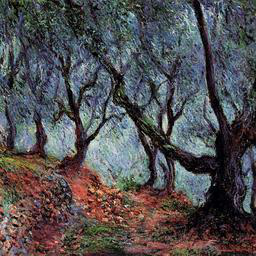

In [38]:
PIL.Image.fromarray(
    (255 * image_loader[1][0].permute(1, 2, 0))
    .numpy()
    .astype(np.uint8)
)